***ASSIGNMENT SOLUTION -  AARTHI THIRUMAVALAVAN***

Contents:

---




*   Imports
*   Reading Input Data
*   Data Pre-processing
*   Essential Functions
*   Train-test split for model input
*   Model design - Baseline
*   SMOTE AND SMOTETOMEK sampling strategy on classifiers
*   One vs Rest dataset split on Classifiers
*   Best Model - Catboost with SMOTE sampling strategy and One-vs-Rest dataset split













# Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import matthews_corrcoef as mcc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
!pip install catboost
import catboost
import matplotlib.pyplot as plt
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

     |████████████████████████████████| 76.1 MB 1.2 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Reading input data

In [ ]:
df_main = pd.read_csv('/content/drive/MyDrive/Micron/Q1_data.csv')
df = df_main.copy()

In [ ]:
df.shape

(10241, 152)

# Data Pre-processing

In [ ]:
#To check for duplicate values
df.drop_duplicates(keep="first",inplace=True)

In [ ]:
df.shape #proves no duplicate rows are present

(10241, 152)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10241 entries, 0 to 10240
Columns: 152 entries, 0 to target
dtypes: float64(143), int64(9)
memory usage: 12.0 MB


In [ ]:
#To check for null values
df.isnull().any().value_counts()

False    147
True       5
dtype: int64

In [ ]:
df.fillna(method="ffill",inplace=True)

In [ ]:
df['target'].value_counts()

0    10000
1      101
2       59
3       52
4       29
Name: target, dtype: int64

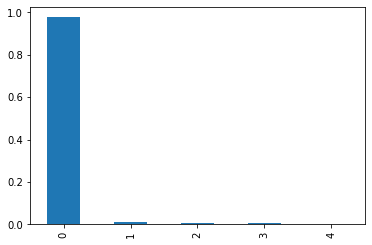

In [ ]:
#Target distribution in dataset
df['target'].value_counts(normalize=True).plot(kind="bar")

In [ ]:
#Distribution of float and int datatypes in the dataset
df.dtypes.value_counts()

float64    143
int64        9
dtype: int64

**Normalization and Standardization of dataset**

In [ ]:
#Normalization of dataset
norm = MinMaxScaler().fit_transform(df.drop('target',axis=1).values)
pd.DataFrame(norm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150
0,0.101724,0.029776,0.062929,0.623310,0.021386,0.022632,0.019447,0.621639,0.025841,0.260170,0.064564,0.075057,0.003672,0.536461,0.031011,0.457383,0.042836,0.022252,0.224006,0.116258,0.551649,0.263242,0.130858,0.000097,0.175314,0.317520,0.616557,0.043108,0.074161,0.065702,0.013334,0.038237,0.471972,0.134564,0.067579,0.117843,0.139478,0.026804,0.503864,0.013739,...,0.679008,0.190292,0.400000,0.026366,0.008412,0.904658,0.019225,0.793347,0.223521,0.086735,0.931911,0.260225,0.514515,0.310123,0.207216,0.320051,0.048744,0.772251,0.908139,0.598463,0.260550,0.452753,0.013346,0.652996,0.015334,0.227611,0.076653,0.577633,0.072140,0.461526,0.446814,0.645971,0.039490,0.575194,0.850136,0.183208,0.840474,0.413013,0.448460,0.201133
1,0.104126,0.016637,0.054497,0.343901,0.025502,0.025125,0.149282,0.363075,0.024354,0.273569,0.066245,0.263259,0.003672,0.543657,0.027433,0.108321,0.030970,0.023432,0.304639,0.738191,0.851835,0.173169,0.085524,0.000554,0.546985,0.142946,0.614138,0.051963,0.078354,0.027745,0.013826,0.044039,0.244787,0.035119,0.067406,0.391294,0.128158,0.026320,0.482547,0.020822,...,0.714569,0.516983,0.133333,0.021263,0.013488,0.249272,0.017707,0.356519,0.211925,0.144770,0.635637,0.020330,0.317805,0.271594,0.232141,0.852692,0.317969,0.819605,0.589945,0.668468,0.667604,0.466591,0.012154,0.652014,0.007119,0.334974,0.111568,0.635343,0.033274,0.466487,0.423277,0.465174,0.034991,0.320416,0.865218,0.234139,0.694571,0.395686,0.272417,0.195889
2,0.068141,0.025432,0.055903,0.635276,0.021586,0.021320,0.018033,0.502120,0.021379,0.135659,0.182025,0.090951,0.004896,0.562581,0.024571,0.338656,0.040810,0.023601,0.137171,0.071036,0.811086,0.255188,0.140021,0.000486,0.339515,0.269663,0.122441,0.035589,0.069182,0.060596,0.011710,0.044072,0.610675,0.129188,0.062727,0.070730,0.356782,0.025997,0.568079,0.009986,...,0.483446,0.354507,0.200000,0.018711,0.011603,0.419214,0.009511,0.767809,0.249026,0.153699,0.436687,0.017819,0.412497,0.286358,0.122407,0.134167,0.240940,0.821727,0.239697,0.242020,0.612422,0.439105,0.013346,0.664784,0.009858,0.912726,0.077348,0.488141,0.074594,0.394753,0.674122,0.557913,0.031992,0.472277,0.686535,0.161211,0.773346,0.358557,0.327330,0.233047
3,0.070115,0.033591,0.373985,0.801243,0.027912,0.016990,0.020720,0.298736,0.026957,0.175572,0.078802,0.070634,0.004896,0.534227,0.376670,0.399209,0.042981,0.024612,0.155472,0.487917,0.849576,0.169384,0.040592,0.012817,0.547577,0.047233,0.227148,0.025397,0.071017,0.065191,0.011415,0.040759,0.532141,0.134026,0.054930,0.036539,0.508389,0.027127,0.707034,0.027479,...,0.415822,0.444504,0.600000,0.028280,0.015518,0.653930,0.014570,0.269153,0.433383,0.135204,0.720156,0.013992,0.335776,0.302751,0.164837,0.845909,0.191943,0.817880,0.783291,0.788127,0.443627,0.460146,0.012631,0.662328,0.020263,0.842903,0.074325,0.455045,0.071321,0.315949,0.565150,0.520474,0.038740,0.298968,0.264791,0.153224,0.649753,0.748939,0.270657,0.359184
4,0.101594,0.023630,0.375390,0.342968,0.025000,0.026371,0.024468,0.302509,0.022867,0.163605,0.169270,0.270279,0.003672,0.529468,0.029580,0.120079,0.011505,0.024612,0.215852,0.897473,0.668672,0.192851,0.038823,0.012757,0.561057,0.317520,0.526681,0.052632,0.078092,0.027064,0.013432,0.036793,0.437345,0.215194,0.067753,0.362651,0.532242,0.031326,0.514122,0.021813,...,0.600418,0.581171,0.000000,0.024240,0.014068,0.711426,0.020136,0.361559,0.199717,0.113520,0.470129,0.026668,0.474150,0.265004,0.092563,0.362442,0.199015,0.823186,0.288384,0.520942,0.487557,0.509146,0.013108,0.667976,0.003012,0.661357,0.063042,0.489396,0.244375,0.531404,0.694408,0.375400,0.034491,0.266222,0.593548,0.087375,0.861007,0.454031,0.248016,0.251950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
#Data Standardization
sc = StandardScaler()
std = sc.fit_transform(norm)
std

array([[ 0.38243998, -0.23861713, -0.31153198, ..., -0.42422882,
         1.39091342, -1.10978328],
       [ 0.45707678, -0.44603864, -0.39621069, ..., -0.50533914,
        -0.67756249, -1.16217142],
       [-0.66119443, -0.30720005, -0.38209757, ..., -0.67914698,
        -0.03234748, -0.79092709],
       ...,
       [-0.02690288, -0.3858195 , -0.38052945, ...,  0.56068229,
        -0.67993495, -1.62752036],
       [-0.08986789, -0.28879975,  2.43111736, ..., -0.52023696,
         0.24910389, -1.46712211],
       [-0.57539841, -0.3490189 , -0.27076075, ..., -0.81488263,
         0.96909826, -1.66923684]])

In [ ]:
X_nstd = pd.DataFrame(std)
X = pd.concat([X_nstd, df_main['target']],axis=1)
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,target
0,0.382440,-0.238617,-0.311532,1.088893,-0.393482,-0.213872,-0.387492,1.750402,-0.062926,0.933787,-0.707488,-0.500189,-0.176138,0.032384,-0.324696,1.113488,-0.161432,-0.164954,0.766833,-1.355660,-0.352807,0.591209,0.596269,-0.235299,-1.678992,0.360199,0.374389,-0.236662,-0.077710,0.050640,-0.153725,-0.164894,-0.173249,0.026714,-0.083737,-0.229578,-0.820150,-0.091822,-0.690484,-0.451554,...,-3.672354,-0.337156,0.035959,-0.152925,1.563026,-0.091852,1.161925,-0.600015,-1.182788,1.756109,3.172041,0.268873,0.364959,1.004888,-0.759294,-1.558380,-2.408748,1.623176,0.472226,-2.190699,0.055044,-0.056567,-0.467249,-0.028683,-1.060048,-0.403640,0.263341,-0.104191,0.364673,-0.667016,0.720459,0.102919,1.383126,1.088839,0.816223,0.771606,-0.424229,1.390913,-1.109783,0
1,0.457077,-0.446039,-0.396211,-0.796533,-0.350809,-0.163167,1.961015,-0.214407,-0.099545,1.132444,-0.691684,1.673859,-0.176138,0.181867,-0.364835,-1.402629,-0.394222,-0.151682,1.970126,0.862492,0.908734,-0.566766,0.121836,-0.217240,0.210901,-1.894167,0.364322,-0.141020,-0.002311,-0.950094,-0.138727,0.177474,-1.945066,-1.644559,-0.086402,2.322001,-0.880916,-0.104941,-0.850916,-0.357521,...,0.056526,-1.195105,-0.145491,-0.064670,-0.999847,-0.117632,-1.173620,-0.716639,0.099329,-0.023445,-0.262908,-1.180387,-0.126822,1.521568,1.434933,1.094874,0.127318,0.355954,0.767280,1.121999,0.200562,-0.083064,-0.510185,-0.188725,-0.636996,0.075542,0.644502,-0.708013,0.401436,-0.851383,-1.073923,-0.010652,-0.722755,1.167961,1.632029,0.333067,-0.505339,-0.677562,-1.162171,0
2,-0.661194,-0.307200,-0.382098,1.169637,-0.391401,-0.240560,-0.413075,0.842184,-0.172782,-0.912195,0.396942,-0.316589,-0.107198,0.574976,-0.396947,0.257675,-0.201177,-0.149786,-0.529028,-1.516945,0.737483,0.487657,0.692165,-0.219905,-0.844055,-0.257804,-1.682512,-0.317867,-0.167246,-0.083988,-0.203217,0.179449,0.908492,-0.063625,-0.158373,-0.669189,0.346355,-0.113686,-0.207183,-0.501391,...,-1.797993,-0.980618,-0.236215,-0.097450,-0.335293,-0.256844,1.025385,-0.343521,0.296577,-1.218425,-0.298867,-0.482746,0.061627,-0.753136,-1.525047,0.335735,0.240979,-1.038921,-1.030090,0.672909,-0.088481,-0.056567,0.047985,-0.135378,1.639580,-0.394109,-0.327734,-0.066055,-0.130079,1.113496,-0.153509,-0.086367,0.532458,0.230550,0.463881,0.569843,-0.679147,-0.032347,-0.790927,0
3,-0.599845,-0.178398,2.812172,2.289568,-0.325830,-0.328627,-0.364468,-0.703315,-0.035462,-0.320458,-0.573618,-0.551280,-0.107198,-0.014017,3.552762,0.694156,-0.158594,-0.138410,-0.255921,-0.030124,0.899241,-0.615434,-0.348392,0.267980,0.213910,-3.130172,-1.246637,-0.427945,-0.134259,0.037177,-0.212216,-0.016044,0.296003,0.017680,-0.278325,-0.988228,1.160195,-0.083077,0.838634,-0.269131,...,-0.770757,0.306306,0.104002,-0.029368,0.582560,-0.170910,-1.640729,1.510539,-0.112009,0.484215,-0.353662,-1.047988,0.270868,0.126412,1.406992,-0.147128,0.034968,1.125963,1.271611,-0.700778,0.132787,-0.072465,-0.059355,0.067342,1.364448,-0.435595,-0.546330,-0.116904,-0.713978,0.259910,-0.525080,0.083990,-0.900036,-1.982010,0.335938,0.198361,1.148318,-0.698244,0.469299,0
4,0.378408,-0.335637,2.826285,-0.802825,-0.356014,-0.137814,-0.296673,-0.674646,-0.136163,-0.497866,0.277017,1.754949,-0.176138,-0.112874,-0.340751,-1.317874,-0.776053,-0.138410,0.645138,1.430579,0.138986,-0.313741,-0.366898,0.265612,0.282457,0.360199,0.000254,-0.133802,-0.007023,-0.968045,-0.150725,-0.250070,-0.443311,1.381800,-0.081071,2.054729,1.288239,0.030613,-0.613276,-0.344357,...,0.789176,-1.624080,-0.039645,-0.054584,0.807398,-0.076383,-1.146671,-0.839410,-0.591042,-1.017560,-0.172154,-0.028516,-0.210932,-1.371790,-0.584664,-0.077436,0.319121,-0.845023,0.145497,-0.343267,0.648081,-0.061867,0.187528,-0.268746,0.649086,-0.590447,-0.3

# Essential Functions

In [ ]:
#Splitting dataset to form validation set
def split(df):
  x_train, x_val, y_train, y_val = train_test_split(df.drop(['target'], axis=1), \
                                                  df['target'].astype('int'),
                                                    test_size=0.20,shuffle=True,
                                                    random_state=0,
                                                    stratify=df['target'])
  return x_train, x_val, y_train, y_val

In [ ]:
#Prediction report
from sklearn.metrics import matthews_corrcoef
def evaluate_model(y_true, y_pred, index_values):
  print('Classification report')
  print('-'*75)
  print(classification_report(y_true,y_pred))
  print('Confusion matrix')
  print('-'*75)
  cm = confusion_matrix(y_true, y_pred)
  cm_df = pd.DataFrame(cm.T, index=index_values, columns=index_values)
  cm_df.index.name = 'Predicted'
  cm_df.columns.name = 'True'
  print(cm_df)
  print('')
  print('Matthew Correlation coefficient')
  print('-'*75)
  print( matthews_corrcoef(y_true, y_pred))

In [ ]:
#Over sampling and under sampling
def sampling_strategy(kind = "SMOTETOMEK"):
  if(kind == "SMOTE"):
    oversample = SMOTE(random_state=42)
    X, y = oversample.fit_resample(x_train, y_train)
  else:
    smt = SMOTETomek(random_state=42)
    X, y = smt.fit_resample(x_train, y_train)

  return X,y

# Train-test split for model input

In [ ]:
#Class-wise distribution of target field
x_train, x_test, y_train, y_test = split(X)
train = pd.concat([x_train,y_train],axis=1)
test = pd.concat([x_test, y_test],axis=1)
print("Train dataset")
print(train['target'].value_counts())
print("Test dataset")
print(test['target'].value_counts())

Train dataset
0    7999
1      81
2      47
3      42
4      23
Name: target, dtype: int64
Test dataset
0    2001
1      20
2      12
3      10
4       6
Name: target, dtype: int64


# Model design - Baseline

**(a) LGBM Classifier**

In [ ]:
model1 = lgb.LGBMClassifier(random_state=0, n_estimators=500,
                           learning_rate=0.1, num_leaves=31,
                           is_unbalance=True)

In [ ]:
index_values = list(train.sort_values(by="target")['target'].unique())
x_train, x_val, y_train, y_val = split(train)

model1.fit(x_train, y_train, eval_set=(x_val,y_val), verbose=0)
val_pred = model1.predict(x_val)

evaluate_model(y_val, val_pred, index_values)

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1600
           1       0.75      0.19      0.30        16
           2       1.00      1.00      1.00        10
           3       0.62      0.62      0.62         8
           4       1.00      0.20      0.33         5

    accuracy                           0.99      1639
   macro avg       0.87      0.60      0.65      1639
weighted avg       0.99      0.99      0.98      1639

Confusion matrix
---------------------------------------------------------------------------
True          0   1   2  3  4
Predicted                    
0          1599  12   0  2  3
1             0   3   0  1  0
2             0   0  10  0  0
3             1   1   0  5  1
4             0   0   0  0  1

Matthew Correlation coefficient
---------------------------------------------------------------------------
0

**(b) Random Forest Classifier**

In [ ]:
model2 = RandomForestClassifier(max_depth=2, random_state=0)

In [ ]:
index_values = list(train.sort_values(by="target")['target'].unique())
x_train, x_val, y_train, y_val = split(train)

model2.fit(x_train, y_train)
val_pred = model2.predict(x_val)

evaluate_model(y_val, val_pred, index_values)

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1600
           1       0.00      0.00      0.00        16
           2       1.00      1.00      1.00        10
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         5

    accuracy                           0.98      1639
   macro avg       0.40      0.40      0.40      1639
weighted avg       0.96      0.98      0.97      1639

Confusion matrix
---------------------------------------------------------------------------
True          0   1   2  3  4
Predicted                    
0          1600  16   0  8  5
1             0   0   0  0  0
2             0   0  10  0  0
3             0   0   0  0  0
4             0   0   0  0  0

Matthew Correlation coefficient
---------------------------------------------------------------------------
0

**(c) Catboost Classifier**

In [ ]:
model3 = catboost.CatBoostClassifier(n_estimators=2500,random_state=0, learning_rate=0.03, verbose=100, early_stopping_rounds=50,auto_class_weights="Balanced")

In [ ]:
index_values = list(train.sort_values(by="target")['target'].unique())
x_train, x_val, y_train, y_val = split(train)

model3.fit(x_train, y_train)
val_pred = model3.predict(x_val)

evaluate_model(y_val, val_pred, index_values)

0:	learn: 1.5761818	total: 323ms	remaining: 13m 27s
100:	learn: 0.4756234	total: 15.7s	remaining: 6m 13s
200:	learn: 0.2160599	total: 31s	remaining: 5m 54s
300:	learn: 0.1066280	total: 46.7s	remaining: 5m 40s
400:	learn: 0.0513933	total: 1m 2s	remaining: 5m 26s
500:	learn: 0.0297073	total: 1m 17s	remaining: 5m 9s
600:	learn: 0.0203882	total: 1m 32s	remaining: 4m 53s
700:	learn: 0.0157802	total: 1m 47s	remaining: 4m 36s
800:	learn: 0.0133208	total: 2m 2s	remaining: 4m 20s
900:	learn: 0.0116024	total: 2m 17s	remaining: 4m 3s
1000:	learn: 0.0103457	total: 2m 31s	remaining: 3m 46s
1100:	learn: 0.0092859	total: 2m 46s	remaining: 3m 31s
1200:	learn: 0.0085228	total: 3m 1s	remaining: 3m 16s
1300:	learn: 0.0078637	total: 3m 16s	remaining: 3m 1s
1400:	learn: 0.0072819	total: 3m 31s	remaining: 2m 45s
1500:	learn: 0.0069055	total: 3m 45s	remaining: 2m 30s
1600:	learn: 0.0065851	total: 4m	remaining: 2m 15s
1700:	learn: 0.0062234	total: 4m 15s	remaining: 2m
1800:	learn: 0.0059204	total: 4m 30s	rema

# SMOTE AND SMOTETOMEK sampling strategy on classifiers

**(a) On LGBM classifier**

  (i) SMOTE sampling strategy

In [ ]:
index_values = list(train.sort_values(by="target")['target'].unique())
x_train, x_val, y_train, y_val = split(train)

X,y = sampling_strategy("SMOTE")
model1.fit(X, y, eval_set=(x_val,y_val), verbose=0)
val_pred = model1.predict(x_val)

evaluate_model(y_val, val_pred, index_values)

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1600
           1       0.86      0.38      0.52        16
           2       1.00      0.90      0.95        10
           3       0.80      0.50      0.62         8
           4       0.80      0.80      0.80         5

    accuracy                           0.99      1639
   macro avg       0.89      0.71      0.78      1639
weighted avg       0.99      0.99      0.99      1639

Confusion matrix
---------------------------------------------------------------------------
True          0  1  2  3  4
Predicted                  
0          1599  9  1  3  1
1             0  6  0  1  0
2             0  0  9  0  0
3             0  1  0  4  0
4             1  0  0  0  4

Matthew Correlation coefficient
---------------------------------------------------------------------------
0.7509652128201

(ii) SMOTETOMEK sampling strategy

In [ ]:
index_values = list(train.sort_values(by="target")['target'].unique())
x_train, x_val, y_train, y_val = split(train)

X,y = sampling_strategy("SMOTETOMEK")
model1.fit(X, y, eval_set=(x_val,y_val), verbose=0)
val_pred = model1.predict(x_val)

evaluate_model(y_val, val_pred, index_values)

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1600
           1       0.86      0.38      0.52        16
           2       1.00      0.90      0.95        10
           3       0.80      0.50      0.62         8
           4       0.80      0.80      0.80         5

    accuracy                           0.99      1639
   macro avg       0.89      0.71      0.78      1639
weighted avg       0.99      0.99      0.99      1639

Confusion matrix
---------------------------------------------------------------------------
True          0  1  2  3  4
Predicted                  
0          1599  9  1  3  1
1             0  6  0  1  0
2             0  0  9  0  0
3             0  1  0  4  0
4             1  0  0  0  4

Matthew Correlation coefficient
---------------------------------------------------------------------------
0.7509652128201

**(b) Random Forest Classifier**

(i) SMOTE sampling strategy

In [ ]:
index_values = list(train.sort_values(by="target")['target'].unique())
x_train, x_val, y_train, y_val = split(train)

X,y = sampling_strategy("SMOTE")
model2.fit(X, y)
val_pred = model2.predict(x_val)

evaluate_model(y_val, val_pred, index_values)

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.64      0.78      1600
           1       0.08      0.38      0.13        16
           2       0.83      1.00      0.91        10
           3       0.01      0.62      0.02         8
           4       0.10      0.80      0.17         5

    accuracy                           0.64      1639
   macro avg       0.40      0.69      0.40      1639
weighted avg       0.97      0.64      0.76      1639

Confusion matrix
---------------------------------------------------------------------------
True          0  1   2  3  4
Predicted                   
0          1019  6   0  3  1
1            73  6   0  0  0
2             2  0  10  0  0
3           469  4   0  5  0
4            37  0   0  0  4

Matthew Correlation coefficient
---------------------------------------------------------------------------
0.141726

(ii) SMOTETOMEK sampling strategy

In [ ]:
index_values = list(train.sort_values(by="target")['target'].unique())
x_train, x_val, y_train, y_val = split(train)

X,y = sampling_strategy("SMOTETOMEK")
model2.fit(X, y)
val_pred = model2.predict(x_val)

evaluate_model(y_val, val_pred, index_values)

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.64      0.78      1600
           1       0.08      0.38      0.13        16
           2       0.83      1.00      0.91        10
           3       0.01      0.62      0.02         8
           4       0.10      0.80      0.17         5

    accuracy                           0.64      1639
   macro avg       0.40      0.69      0.40      1639
weighted avg       0.97      0.64      0.76      1639

Confusion matrix
---------------------------------------------------------------------------
True          0  1   2  3  4
Predicted                   
0          1019  6   0  3  1
1            73  6   0  0  0
2             2  0  10  0  0
3           469  4   0  5  0
4            37  0   0  0  4

Matthew Correlation coefficient
---------------------------------------------------------------------------
0.141726

**(c) Catboost classifier**

(i) SMOTE sampling strategy

In [ ]:
index_values = list(train.sort_values(by="target")['target'].unique())
x_train, x_val, y_train, y_val = split(train)

X,y = sampling_strategy("SMOTE")
model3.fit(X, y, eval_set=(x_val,y_val), verbose=0)
val_pred = model3.predict(x_val)

evaluate_model(y_val, val_pred, index_values)

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1600
           1       0.73      0.50      0.59        16
           2       1.00      1.00      1.00        10
           3       0.50      0.50      0.50         8
           4       0.80      0.80      0.80         5

    accuracy                           0.99      1639
   macro avg       0.80      0.76      0.78      1639
weighted avg       0.99      0.99      0.99      1639

Confusion matrix
---------------------------------------------------------------------------
True          0  1   2  3  4
Predicted                   
0          1595  6   0  3  1
1             2  8   0  1  0
2             0  0  10  0  0
3             2  2   0  4  0
4             1  0   0  0  4

Matthew Correlation coefficient
---------------------------------------------------------------------------
0.751756

(ii) SMOTETOMEK sampling strategy

In [ ]:
index_values = list(train.sort_values(by="target")['target'].unique())
x_train, x_val, y_train, y_val = split(train)

X,y = sampling_strategy("SMOTETOMEK")
model3.fit(X, y, eval_set=(x_val,y_val), verbose=0)
val_pred = model3.predict(x_val)

evaluate_model(y_val, val_pred, index_values)

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1600
           1       0.73      0.50      0.59        16
           2       1.00      1.00      1.00        10
           3       0.50      0.50      0.50         8
           4       0.80      0.80      0.80         5

    accuracy                           0.99      1639
   macro avg       0.80      0.76      0.78      1639
weighted avg       0.99      0.99      0.99      1639

Confusion matrix
---------------------------------------------------------------------------
True          0  1   2  3  4
Predicted                   
0          1595  6   0  3  1
1             2  8   0  1  0
2             0  0  10  0  0
3             2  2   0  4  0
4             1  0   0  0  4

Matthew Correlation coefficient
---------------------------------------------------------------------------
0.751756

# One vs Rest dataset split on Classifiers

**(a) LGBM Classifier-  SMOTE sampling strategy**

In [ ]:
onevsrest = train.copy()
model1 = lgb.LGBMClassifier(class_weight="balanced")
onevsrest['target'] = np.where(train['target'] == 0, 0, 999)
x_train, x_val, y_train, y_val = split(onevsrest)
index_values = list(onevsrest['target'].unique())

X, y = sampling_strategy("SMOTE")

model1.fit(X, y, eval_set=(x_val,y_val), verbose=0)
val_pred = model1.predict(x_val)
evaluate_model(y_val, val_pred, index_values)

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1600
         999       0.94      0.74      0.83        39

    accuracy                           0.99      1639
   macro avg       0.96      0.87      0.91      1639
weighted avg       0.99      0.99      0.99      1639

Confusion matrix
---------------------------------------------------------------------------
True        0    999
Predicted           
0          1598   10
999           2   29

Matthew Correlation coefficient
---------------------------------------------------------------------------
0.8305602423741267


In [ ]:
model_1 = lgb.LGBMClassifier(random_state=0, n_estimators=500,
                           learning_rate=0.1, num_leaves=31,
                           is_unbalance=True)
df.dropna(axis=1,inplace=True)
others = train[train['target'] != 0]
index_values = list(others['target'].unique())

x_train, x_val, y_train, y_val = split(others)

X, y = sampling_strategy("SMOTE")

model_1.fit(X, y, eval_set=(x_val,y_val), verbose=0)
val_pred = model_1.predict(x_val)
evaluate_model(y_val, val_pred, index_values)

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.74      0.88      0.80        16
           2       1.00      1.00      1.00        10
           3       0.71      0.62      0.67         8
           4       1.00      0.60      0.75         5

    accuracy                           0.82        39
   macro avg       0.86      0.78      0.80        39
weighted avg       0.83      0.82      0.82        39

Confusion matrix
---------------------------------------------------------------------------
True        1   2  3  4
Predicted              
1          14   0  3  2
2           0  10  0  0
3           2   0  5  0
4           0   0  0  3

Matthew Correlation coefficient
---------------------------------------------------------------------------
0.7444567936469952


In [ ]:
#Train
final_train = train.copy()
final_train['prediction'] = model1.predict(final_train[x_train.columns])
print(final_train['prediction'].value_counts())
print('')

one_class = final_train[final_train['prediction'] == 0]
other_class = final_train[final_train['prediction'] != 0]
other_class['prediction'] = model_1.predict(other_class[x_train.columns])
final_train_df = pd.concat([one_class, other_class],axis=0)
evaluate_model(final_train_df['target'], final_train_df['prediction'], [0,1,2,3,4])

0      8007
999     185
Name: prediction, dtype: int64

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7999
           1       0.94      0.91      0.92        81
           2       1.00      1.00      1.00        47
           3       0.92      0.83      0.88        42
           4       1.00      0.91      0.95        23

    accuracy                           1.00      8192
   macro avg       0.97      0.93      0.95      8192
weighted avg       1.00      1.00      1.00      8192

Confusion matrix
---------------------------------------------------------------------------
True          0   1   2   3   4
Predicted                      
0          7997   5   0   5   0
1             1  74   0   2   2
2             0   0  47   0   0
3             1   2   0  35   0
4             0   0   0   0  21

Matthew Correlation coefficient
-------

In [ ]:
#Test
final_test = test.copy()
final_test['prediction'] = model1.predict(final_test[x_train.columns])
print(final_test['prediction'].value_counts())
print('')

one_class = final_test[final_test['prediction'] == 0]
other_class = final_test[final_test['prediction'] != 0]
other_class['prediction'] = model_1.predict(other_class[x_train.columns])
final_test_df = pd.concat([one_class, other_class],axis=0)
evaluate_model(final_test_df['target'], final_test_df['prediction'], [0,1,2,3,4])

0      2005
999      44
Name: prediction, dtype: int64

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2001
           1       0.58      0.55      0.56        20
           2       1.00      1.00      1.00        12
           3       0.55      0.60      0.57        10
           4       1.00      0.33      0.50         6

    accuracy                           0.99      2049
   macro avg       0.82      0.70      0.73      2049
weighted avg       0.99      0.99      0.99      2049

Confusion matrix
---------------------------------------------------------------------------
True          0   1   2  3  4
Predicted                    
0          1996   7   0  0  2
1             2  11   0  4  2
2             0   0  12  0  0
3             3   2   0  6  0
4             0   0   0  0  2

Matthew Correlation coefficient
---------------------

**(b) Random Forest Classifier -  SMOTE sampling strategy**

In [ ]:
onevsrest = train.copy()
model2 = RandomForestClassifier(class_weight="balanced")
onevsrest['target'] = np.where(train['target'] == 0, 0, 999)
x_train, x_val, y_train, y_val = split(onevsrest)
index_values = list(onevsrest['target'].unique())

X, y = sampling_strategy("SMOTE")

model2.fit(X, y)
val_pred = model2.predict(x_val)
evaluate_model(y_val, val_pred, index_values)

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1600
         999       0.92      0.56      0.70        39

    accuracy                           0.99      1639
   macro avg       0.95      0.78      0.85      1639
weighted avg       0.99      0.99      0.99      1639

Confusion matrix
---------------------------------------------------------------------------
True        0    999
Predicted           
0          1598   17
999           2   22

Matthew Correlation coefficient
---------------------------------------------------------------------------
0.7141592398954348


In [ ]:
model_2 = RandomForestClassifier(class_weight="balanced")
df.dropna(axis=1,inplace=True)
others = train[train['target'] != 0]
index_values = list(others['target'].unique())

x_train, x_val, y_train, y_val = split(others)

X, y = sampling_strategy("SMOTE")

model_2.fit(X, y)
val_pred = model_2.predict(x_val)
evaluate_model(y_val, val_pred, index_values)

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.65      0.81      0.72        16
           2       1.00      1.00      1.00        10
           3       0.57      0.50      0.53         8
           4       1.00      0.40      0.57         5

    accuracy                           0.74        39
   macro avg       0.81      0.68      0.71        39
weighted avg       0.77      0.74      0.74        39

Confusion matrix
---------------------------------------------------------------------------
True        1   2  3  4
Predicted              
1          13   0  4  3
2           0  10  0  0
3           3   0  4  0
4           0   0  0  2

Matthew Correlation coefficient
---------------------------------------------------------------------------
0.6319982857856848


In [ ]:
#Train
final_train = train.copy()
final_train['prediction'] = model2.predict(final_train[x_train.columns])
print(final_train['prediction'].value_counts())
print('')

one_class = final_train[final_train['prediction'] == 0]
other_class = final_train[final_train['prediction'] != 0]
other_class['prediction'] = model_2.predict(other_class[x_train.columns])
final_train_df = pd.concat([one_class, other_class],axis=0)
evaluate_model(final_train_df['target'], final_train_df['prediction'], [0,1,2,3,4])

0      8014
999     178
Name: prediction, dtype: int64

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7999
           1       0.90      0.88      0.89        81
           2       1.00      1.00      1.00        47
           3       0.91      0.74      0.82        42
           4       1.00      0.78      0.88        23

    accuracy                           1.00      8192
   macro avg       0.96      0.88      0.92      8192
weighted avg       1.00      1.00      1.00      8192

Confusion matrix
---------------------------------------------------------------------------
True          0   1   2   3   4
Predicted                      
0          7997   7   0   8   2
1             2  71   0   3   3
2             0   0  47   0   0
3             0   3   0  31   0
4             0   0   0   0  18

Matthew Correlation coefficient
-------

In [ ]:
#Test
final_test = test.copy()
final_test['prediction'] = model2.predict(final_test[x_train.columns])
print(final_test['prediction'].value_counts())
print('')

one_class = final_test[final_test['prediction'] == 0]
other_class = final_test[final_test['prediction'] != 0]
other_class['prediction'] = model_2.predict(other_class[x_train.columns])
final_test_df = pd.concat([one_class, other_class],axis=0)
evaluate_model(final_test_df['target'], final_test_df['prediction'], [0,1,2,3,4])

0      2016
999      33
Name: prediction, dtype: int64

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2001
           1       0.53      0.40      0.46        20
           2       0.92      0.92      0.92        12
           3       0.75      0.30      0.43        10
           4       1.00      0.33      0.50         6

    accuracy                           0.99      2049
   macro avg       0.84      0.59      0.66      2049
weighted avg       0.99      0.99      0.98      2049

Confusion matrix
---------------------------------------------------------------------------
True          0   1   2  3  4
Predicted                    
0          1998  11   1  4  2
1             2   8   0  3  2
2             1   0  11  0  0
3             0   1   0  3  0
4             0   0   0  0  2

Matthew Correlation coefficient
---------------------

**(c) Catboost Classifier -  SMOTE sampling strategy**

In [ ]:
onevsrest = train.copy()
model3 = catboost.CatBoostClassifier(n_estimators=2500,random_state=0, learning_rate=0.03, verbose=100, early_stopping_rounds=50,auto_class_weights="Balanced")
onevsrest['target'] = np.where(train['target'] == 0, 0, 999)
x_train, x_val, y_train, y_val = split(onevsrest)
index_values = list(onevsrest['target'].unique())

X, y = sampling_strategy("SMOTE")

model3.fit(X, y, eval_set=(x_val,y_val), verbose=0)
val_pred = model3.predict(x_val)
evaluate_model(y_val, val_pred, index_values)

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1600
         999       0.97      0.77      0.86        39

    accuracy                           0.99      1639
   macro avg       0.98      0.88      0.93      1639
weighted avg       0.99      0.99      0.99      1639

Confusion matrix
---------------------------------------------------------------------------
True        0    999
Predicted           
0          1599    9
999           1   30

Matthew Correlation coefficient
---------------------------------------------------------------------------
0.8599477523532122


In [ ]:
model_3 = catboost.CatBoostClassifier(n_estimators=2500,random_state=0, learning_rate=0.03, verbose=100, early_stopping_rounds=50,auto_class_weights="Balanced")
df.dropna(axis=1,inplace=True)
others = train[train['target'] != 0]
index_values = list(others['target'].unique())

x_train, x_val, y_train, y_val = split(others)

X, y = sampling_strategy("SMOTE")

model_3.fit(X, y, eval_set=(x_val,y_val), verbose=0)
val_pred = model_3.predict(x_val)
evaluate_model(y_val, val_pred, index_values)

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.72      0.81      0.76        16
           2       1.00      1.00      1.00        10
           3       0.56      0.62      0.59         8
           4       1.00      0.40      0.57         5

    accuracy                           0.77        39
   macro avg       0.82      0.71      0.73        39
weighted avg       0.79      0.77      0.76        39

Confusion matrix
---------------------------------------------------------------------------
True        1   2  3  4
Predicted              
1          13   0  3  2
2           0  10  0  0
3           3   0  5  1
4           0   0  0  2

Matthew Correlation coefficient
---------------------------------------------------------------------------
0.6708132744529606


# Best Model - Catboost with SMOTE sampling strategy and One-vs-Rest dataset split

In [ ]:
#Train
final_train = train.copy()
final_train['prediction'] = model3.predict(final_train[x_train.columns])
print(final_train['prediction'].value_counts())
print('')

one_class = final_train[final_train['prediction'] == 0]
other_class = final_train[final_train['prediction'] != 0]
other_class['prediction'] = model_3.predict(other_class[x_train.columns])
final_train_df = pd.concat([one_class, other_class],axis=0)
evaluate_model(final_train_df['target'], final_train_df['prediction'], [0,1,2,3,4])

0      8007
999     185
Name: prediction, dtype: int64

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7999
           1       0.93      0.93      0.93        81
           2       1.00      0.94      0.97        47
           3       0.90      0.86      0.88        42
           4       1.00      0.87      0.93        23

    accuracy                           1.00      8192
   macro avg       0.96      0.92      0.94      8192
weighted avg       1.00      1.00      1.00      8192

Confusion matrix
---------------------------------------------------------------------------
True          0   1   2   3   4
Predicted                      
0          7998   3   3   3   0
1             1  75   0   3   2
2             0   0  44   0   0
3             0   3   0  36   1
4             0   0   0   0  20

Matthew Correlation coefficient
-------

In [ ]:
#Test
final_test = test.copy()
final_test['prediction'] = model3.predict(final_test[x_train.columns])
print(final_test['prediction'].value_counts())
print('')

one_class = final_test[final_test['prediction'] == 0]
other_class = final_test[final_test['prediction'] != 0]
other_class['prediction'] = model_3.predict(other_class[x_train.columns])
final_test_df = pd.concat([one_class, other_class],axis=0)
evaluate_model(final_test_df['target'], final_test_df['prediction'], [0,1,2,3,4])

0      2007
999      42
Name: prediction, dtype: int64

Classification report
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2001
           1       0.50      0.55      0.52        20
           2       1.00      0.83      0.91        12
           3       0.43      0.30      0.35        10
           4       1.00      0.50      0.67         6

    accuracy                           0.99      2049
   macro avg       0.78      0.64      0.69      2049
weighted avg       0.99      0.99      0.99      2049

Confusion matrix
---------------------------------------------------------------------------
True          0   1   2  3  4
Predicted                    
0          1997   6   2  1  1
1             3  11   0  6  2
2             0   0  10  0  0
3             1   3   0  3  0
4             0   0   0  0  3

Matthew Correlation coefficient
---------------------

Feature importance

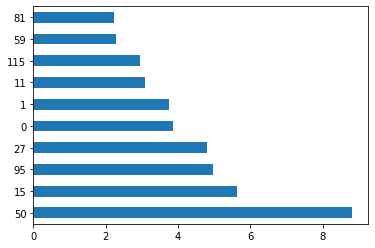

In [ ]:
pd.Series(model3.feature_importances_, index=x_train.columns).nlargest(10).plot(kind='barh')

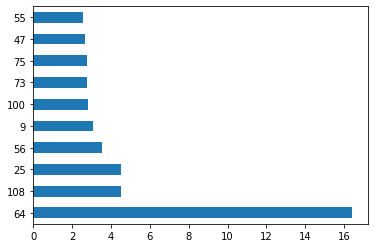

In [ ]:
pd.Series(model_3.feature_importances_, index=x_train.columns).nlargest(10).plot(kind='barh')